# Some references

https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

```
../2017-sourmash-revindex/hashes-to-association.py MS/*.sig -o MS-subset.mat \
    --threshold=2 --intersect \
        ~/dev/2017-sourmash-lca/delmont-genome-sigs/TARA_MED_MAG_000[0-3]*.sig
```

In [1]:
%matplotlib inline
import sourmash_lib, sourmash_lib.fig

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
import hdbscan
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import palettable as pal
import pandas as pd

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


done clustering! 23.823203802108765


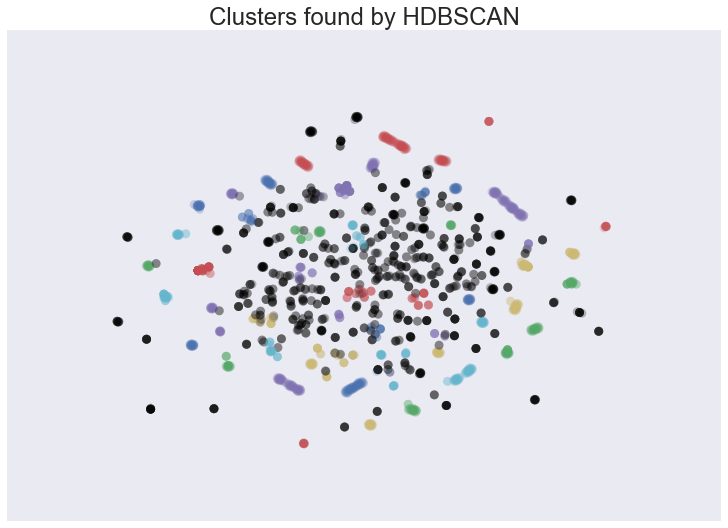

In [7]:
# cluster data using 'algorithm', then use TSNE to plot & color by clustesr
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    #print(labels)
    end_time = time.time()
    
    print('done clustering!', end_time - start_time)
    
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    t = TSNE(n_components=2, perplexity=5).fit_transform(data)

    df = pd.DataFrame(t)
    df.columns=['t1','t2']
    df['colors'] = pd.Series(colors, index=df.index)

    plt.scatter(df.t1, df.t2, c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    return labels
   
# do a quick test run on a small subset
subs2, subs2_labels = sourmash_lib.fig.load_matrix_and_labels('MS-q8.mat')
cluster_labels = plot_clusters(subs2, hdbscan.HDBSCAN, (), {'min_cluster_size':15})

In [8]:
# create a data frame that connects sample_index, cluster label, hash value, and cluster size
def make_sample_df(cluster_labels, sample_labels):
    df_cl = pd.DataFrame(cluster_labels)
    df_cl.index.name = 'sample_index'
    df_cl.columns = ['cluster']
    df_cl['hashval'] = pd.DataFrame(list(map(int, sample_labels)))
    df_cl = df_cl[df_cl.cluster != -1]
    
    df_cl['cluster_size'] = df_cl.groupby('cluster')['cluster'].transform('count')

    return df_cl

# save the hashvals in a given sample df into a signature file.
def save_signature(filename, sample_df, name='', k=31, scaled=100000):
    x = sourmash_lib.MinHash(0, k, scaled=100000)
    x.add_many(list(sample_df.hashval))
    
    print('saving {} hashes to {}'.format(len(sample_df.hashval), filename))

    s = sourmash_lib.SourmashSignature(x, name=name)
    sourmash_lib.save_signatures([s], open(filename, 'wt'))

subs2_df = make_sample_df(cluster_labels, subs2_labels)


In [9]:
subs2_df

,cluster,hashval,cluster_size
sample_index,,,
0,2,161699631335,100
5,29,504755834409,23
6,27,580925234980,48
7,1,595543559490,20
8,15,1068433507887,83
9,3,1254437666872,58
11,31,1328566798407,40
12,2,1463907998924,100
13,2,1506835601275,100


In [11]:
for cluster_id in set(subs2_df.cluster):
    df = subs2_df[subs2_df.cluster == cluster_id]
    save_signature('cluster{}.sig'.format(cluster_id), df, name='cluster{}'.format(cluster_id))

saving 19 hashes to cluster0.sig
saving 20 hashes to cluster1.sig
saving 100 hashes to cluster2.sig
saving 58 hashes to cluster3.sig
saving 48 hashes to cluster4.sig
saving 16 hashes to cluster5.sig
saving 16 hashes to cluster6.sig
saving 25 hashes to cluster7.sig
saving 22 hashes to cluster8.sig
saving 23 hashes to cluster9.sig
saving 34 hashes to cluster10.sig
saving 28 hashes to cluster11.sig
saving 16 hashes to cluster12.sig
saving 23 hashes to cluster13.sig
saving 56 hashes to cluster14.sig
saving 83 hashes to cluster15.sig
saving 23 hashes to cluster16.sig
saving 42 hashes to cluster17.sig
saving 25 hashes to cluster18.sig
saving 23 hashes to cluster19.sig
saving 28 hashes to cluster20.sig
saving 24 hashes to cluster21.sig
saving 27 hashes to cluster22.sig
saving 16 hashes to cluster23.sig
saving 16 hashes to cluster24.sig
saving 15 hashes to cluster25.sig
saving 18 hashes to cluster26.sig
saving 48 hashes to cluster27.sig
saving 17 hashes to cluster28.sig
saving 23 hashes to clu

# Example: select out the two largest clusters and save as a signature.

In [7]:
SELECT_TOP_N=5

xx = list(sorted(set(subs2_df['cluster_size']), reverse=True))[:SELECT_TOP_N]
toptwo = subs2_df[subs2_df.cluster_size.isin(xx)]
save_signature('top.sig', toptwo, name='toptwo')

saving 114 hashes to top.sig


In [21]:
cluster_sizes = list(set(subs2_df.cluster_size))
cluster_sizes.sort()
cluster_sizes.reverse()
cluster_sizes = cluster_sizes[:5]
print(cluster_sizes)


clusters = subs2_df[subs2_df.cluster_size.isin(cluster_sizes)].cluster
set(clusters)

#for cluster_id in df.cluster:
#    print(type(cluster_id), cluster_id)
#    xx = subs2_df[subs2_df.cluster == cluster_id].hashval


[37, 31, 12, 6, 5]


{0, 1, 2, 3, 4, 5, 6}

# Example: TSNE plot just the clusters

In [12]:
#subs2_df = subs2_df[subs2_df.cluster_size < 50]

In [13]:
t = TSNE(n_components=2).fit_transform(subs2)

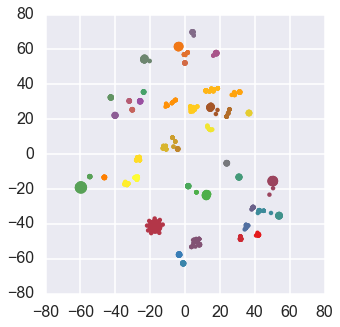

In [14]:
tsne_df=pd.DataFrame(t)
tsne_df.columns=['t1','t2']

subs2_tsne_df = subs2_df.join(tsne_df, how='inner')

fig,ax=plt.subplots(1)
fig.set_size_inches(5,5)
cmap=pal.colorbrewer.qualitative.Set1_7.get_mpl_colormap()

ax.scatter(subs2_tsne_df.t1, subs2_tsne_df.t2, c=subs2_tsne_df.cluster, cmap=cmap, lw=0)

x = sourmash_lib.MinHash(0, 21, scaled=100000)
x.add_many(map(int, subs2_tsne_df.hashval))

s = sourmash_lib.SourmashSignature(x)
sourmash_lib.save_signatures([s], open('all-clusters.sig', 'wt'))

# Example: select only the clusters out of the original matrix

In [15]:

subs2_clusters = subs2[np.ix_(subs2_df.index, subs2_df.index)]
subs2_clusters_labels = [str(x) for x in subs2_df.hashval]

plotting 1260 x 1260 matrix


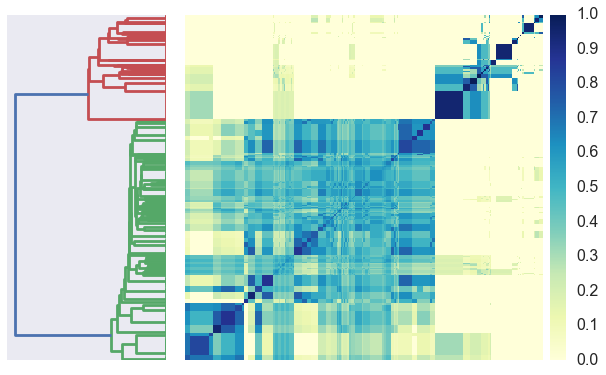

In [17]:
print('plotting {} x {} matrix'.format(*subs2_clusters.shape))
_ = sourmash_lib.fig.plot_composite_matrix(subs2_clusters, subs2_clusters_labels, show_labels=False, show_indices=False)